culane night time

driver 161 90 frame
    1061

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [13]:
# train path
train_path = train_path = "C:\\Users\\User Files\\Documents\\University\\Misc\\4th Year Work\\Final Year Project\\Datasets\\image-footage\\CULane Selected\\Image-Label Couples"

In [14]:
# create a generator and get the images from the directory
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(80, 160)
)

Found 2012 images belonging to 2 classes.


In [15]:
'''
Assign the images in 'images_set' to two seperate arrays:
#assign the road images to 'X' and the ground truth masks to 'Y'
'''
num_images = 2012 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0:
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

# convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

Batch 0
Batch 10
Batch 20
Batch 30


In [16]:
# Normalize and reshape the mask set (Y)
Y = (Y >= 100).astype('int').reshape(-1, 80, 160, 1)

In [17]:
Y.min(), Y.max()

(0, 1)

In [18]:
# we get 1006 images for training and evaluation
X = np.array(X[:1006])
Y = np.array(Y[:1006])

In [19]:
# Split the datset into train and val sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)

In [20]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)

Shape of X_train: (905, 80, 160, 3)
Shape of X_val: (101, 80, 160, 3)
Shape of Y_train: (905, 80, 160, 1)
Shape of Y_val: (101, 80, 160, 1)


In [21]:
# free the RAM from undesired clutters
import gc
del X, Y, images_set
gc.collect()

21434

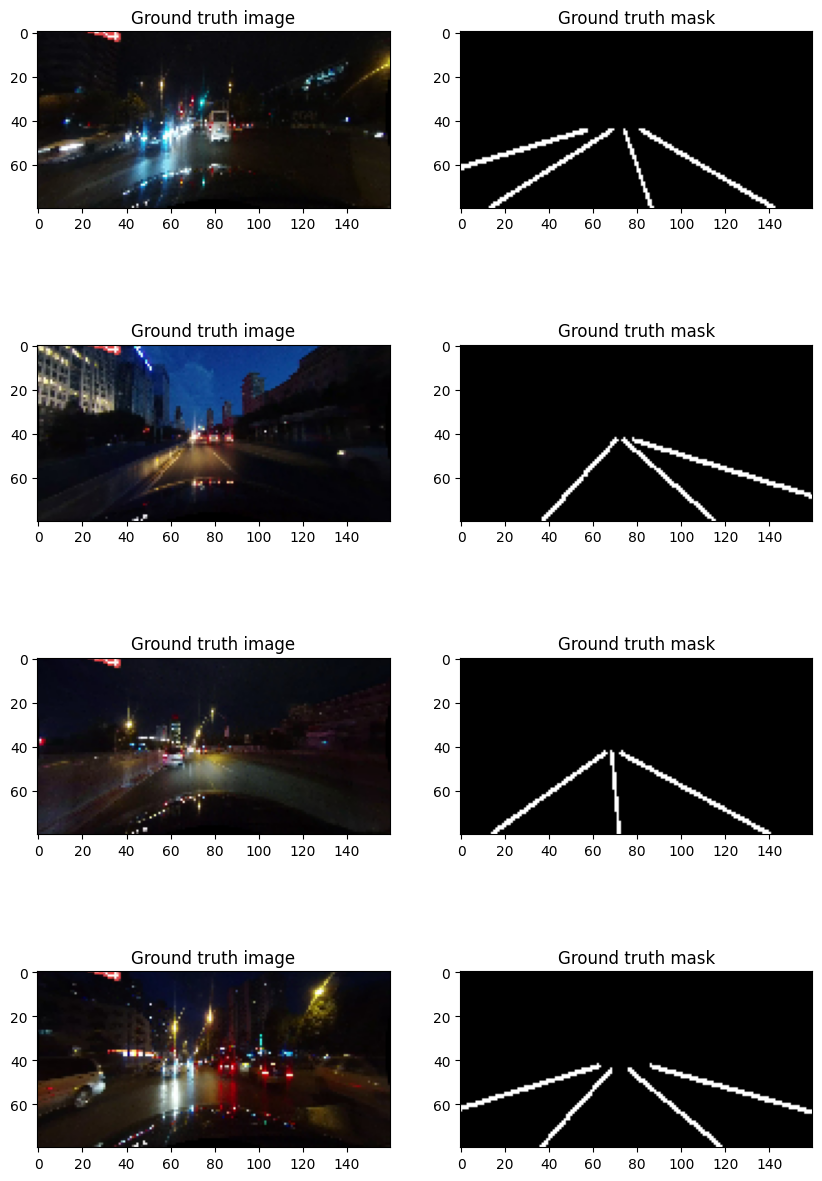

In [22]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Ground truth mask')
    index += 2

In [23]:
# define the model's architecture

from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from keras.models import Model

def unet(input_size=(80,160,3)):
    inputs = Input(input_size)
    rescale = keras.layers.Rescaling(1./255)(inputs)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(rescale)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Decoder
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 rescaling (Rescaling)          (None, 80, 160, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 160, 64)  1792        ['rescaling[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 80, 160, 64)  36928       ['conv2d[0][0]']             

In [24]:
# Compile the model
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy())

In [25]:
import os
# train the model
epochs = 50
batch_size = 8

# save the callback files
model_path = "C:\\Users\\User Files\\Documents\\University\\Misc\\4th Year Work\\Final Year Project\\Models\\UNet\\Combined"

# save weights for each epochs
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_path, "save_at_{epoch}.h5")
    ),
]

model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/50
114/114 [==============================] - 20s 159ms/step - loss: 0.4974 - val_loss: 0.0290
Epoch 2/50
114/114 [==============================] - 17s 151ms/step - loss: 0.0289 - val_loss: 0.0274
Epoch 3/50
114/114 [==============================] - 17s 152ms/step - loss: 0.0273 - val_loss: 0.0274
Epoch 4/50
114/114 [==============================] - 17s 152ms/step - loss: 0.0263 - val_loss: 0.0255
Epoch 5/50
114/114 [==============================] - 17s 152ms/step - loss: 0.0248 - val_loss: 0.0242
Epoch 6/50
114/114 [==============================] - 17s 153ms/step - loss: 0.0236 - val_loss: 0.0232
Epoch 7/50
114/114 [==============================] - 17s 153ms/step - loss: 0.0225 - val_loss: 0.0233
Epoch 8/50
114/114 [==============================] - 17s 153ms/step - loss: 0.0214 - val_loss: 0.0218
Epoch 9/50
114/114 [==============================] - 17s 152ms/step - loss: 0.0206 - val_loss: 0.0210
Epoch 10/50
114/114 [==============================] - 17s 153ms/step - l

In [26]:
# save the model
model.save(f"{model_path}\\combined_model.h5")

In [27]:
#model = tf.keras.models.load_model(f"{model_path}\\night_model.h5")  # trained model
preds = model.predict(X_val)
preds.max(), preds.min()

4/4 [==============================] - 1s 217ms/step


(0.99998534, 0.0)

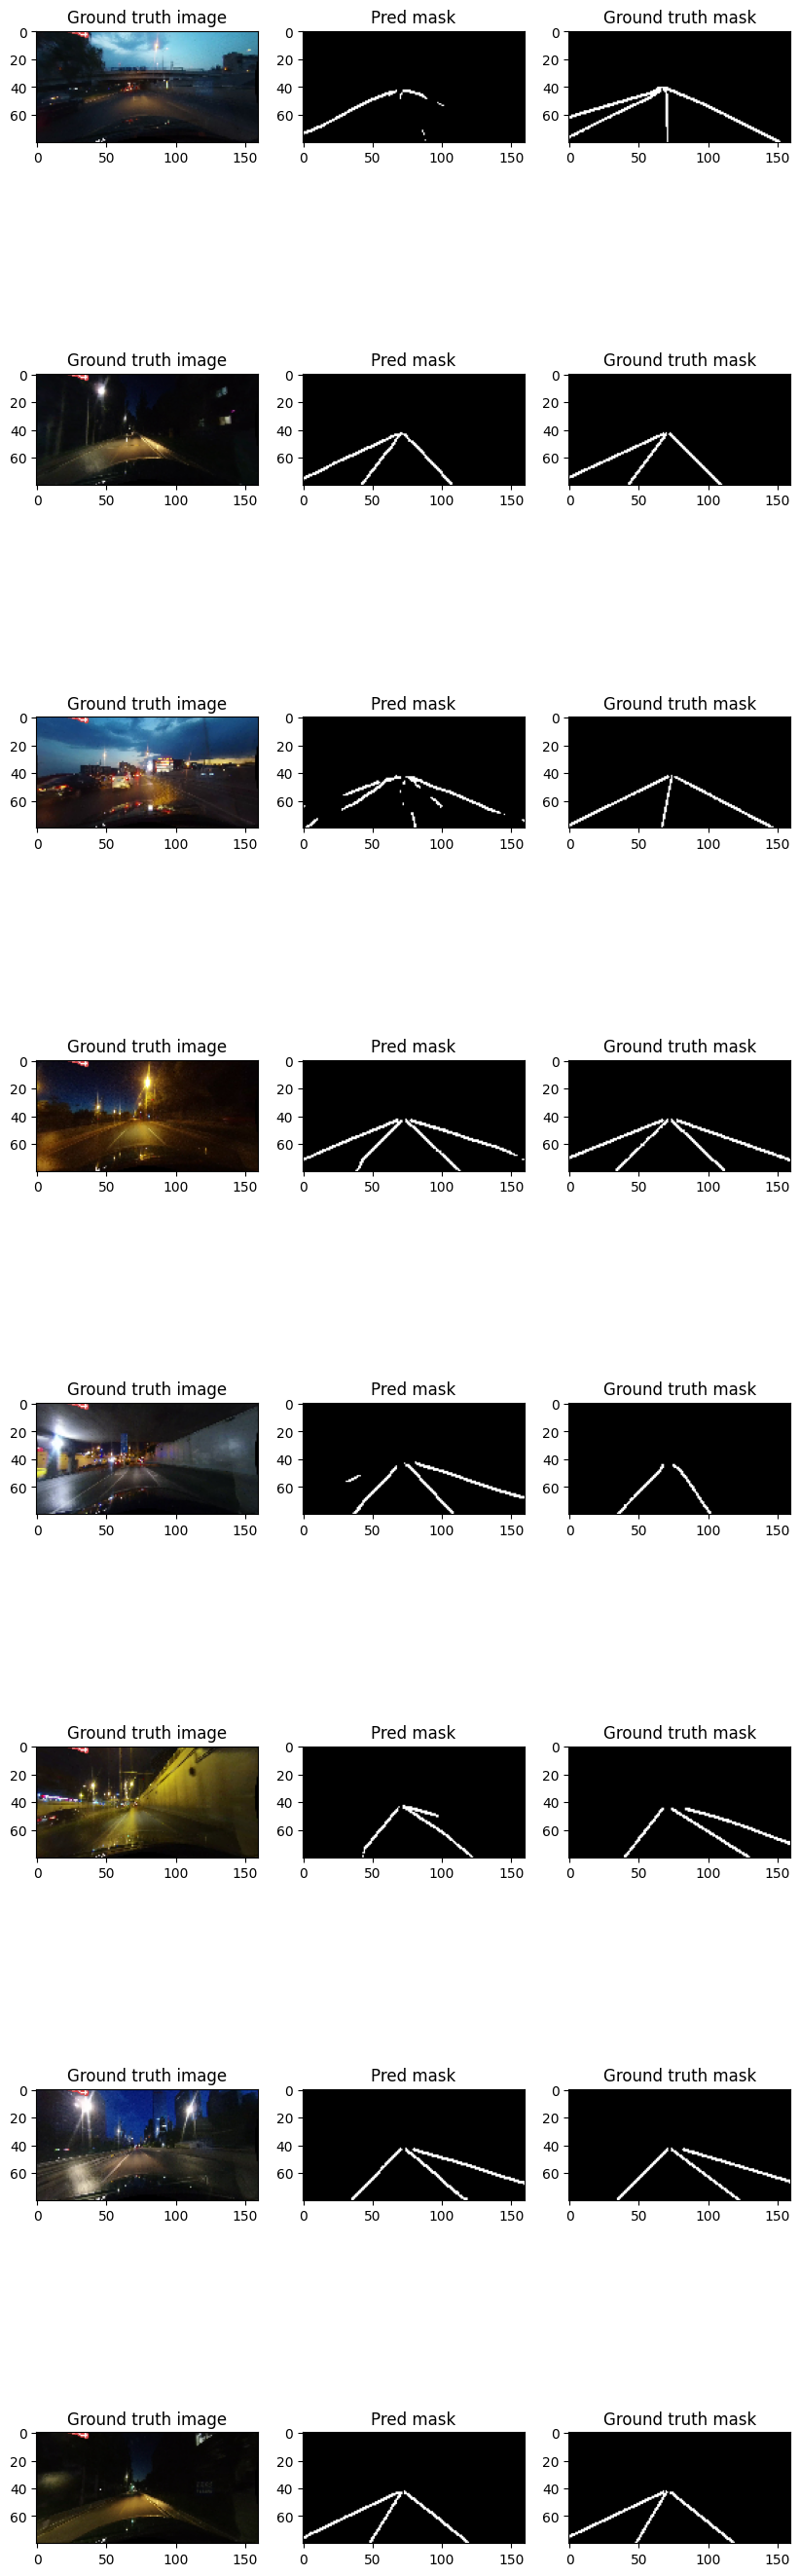

In [28]:
# visualize some results from the validation set.
out_dir = "C:\\Users\\User Files\\Documents\\University\\Misc\\4th Year Work\\Final Year Project\\Outputs\\Model Outputs\\UNet"
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):

    # write these images into file as well
    cv2.imwrite(f"{out_dir}\\img-{index}.jpg", i)
    cv2.imwrite(f"{out_dir}\\pred-{index}.jpg", j*255.)
    cv2.imwrite(f"{out_dir}\\ground-{index}.jpg", k*255.)

    plt.subplot(10, 3, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 3, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')

    plt.subplot(10, 3, index+2)
    plt.imshow(k, cmap='gray')
    plt.title('Ground truth mask')
    index += 3

In [29]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])


# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recal:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

Accuracy: 0.97495127
Precision: 0.65209377
Recal: 0.60430205
F1 Score:  0.627288939899619
IoU:  0.33333334
